# Find subtype enrichment within certain niches

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams

import numpy as np
import pandas as pd
import scanpy as sc

import tqdm.auto as tqdm

import seaborn as sns
from scipy.stats import fisher_exact
rcParams['figure.facecolor'] = (1,1,1,1)

In [2]:
adata = sc.read_h5ad("/storage/codex/datasets_v1/bladder_merged_v10.h5ad")
adata

AnnData object with n_obs × n_vars = 598327 × 1440
    obs: 'CD45_ringpct', 'CD20_ringpct', 'CD3e_ringpct', 'CD45RO_ringpct', 'CD45RA_ringpct', 'CD8_ringpct', 'CD4_ringpct', 'CDH12_ringpct', 'KRT13_ringpct', 'KRT17_ringpct', 'PanCytoK_ringpct', 'ERBB2_ringpct', 'sample_id', 'sample_id_printing', 'snSeq_sample', 'patient', 'biopsy', 'Filtered_DAPI', 'cell_gates', 'celltype_gating', 'subtype_gates', 'subtype_gating', 'subtype_rescued', 'subtype', 'celltype', 'cell_niches', 'niche_labels'
    uns: 'celltype_colors', 'channels', 'niche_labels_colors', 'niche_profiles_colnames', 'patient_colors', 'sample_id_printing_colors', 'sample_layout', 'snSeq_sample_colors', 'subtype_colors', 'subtype_gating_colors'
    obsm: 'coordinates', 'coordinates_shift', 'niche_profiles'

In [3]:
niches = np.array(adata.obs.niche_labels)
subtypes = np.array(adata.obs.subtype)
celltypes = np.array(adata.obs.celltype)
samples = np.array(adata.obs.sample_id)

In [5]:
np.unique(niches)

array(['Bcell', 'Bcell;CD4T', 'CD4T', 'CD4T;CD8T;Mac',
       'CD4T;CD8T;Stromal', 'CD8T', 'CD8T;Endothelial;Stromal',
       'CD8T;Mac', 'Endothelial', 'Endothelial;Epithelial;Mac',
       'Endothelial;Epithelial_CDH;Mac', 'Endothelial;Mac;Stromal',
       'Epithelial', 'Epithelial;Epithelial_CDH', 'Epithelial;Stromal',
       'Epithelial_CDH', 'Mac', 'Mac;Stromal', 'Stromal'], dtype=object)

In [8]:
u_niches = np.unique(niches)
u_subtypes = np.unique(subtypes)

In [10]:
import itertools

"""
Test this contingency table:

                    in query niche  |  in other niche
                   -----------------|-----------------
   target subtype |        A        |        B        |
------------------|-----------------|-----------------|
reference subtype |        C        |        D        |
                   -----------------|-----------------

"""

def get_ctable_counts(niches, subtypes, query_niche, target_subtype):
    A = np.sum((niches==query_niche) & (subtypes==target_subtype))
    B = np.sum((niches!=query_niche) & (subtypes==target_subtype))
    # C = np.sum((niches==query_niche) & (subtypes==other_subtype))
    # D = np.sum((niches!=query_niche) & (subtypes==other_subtype))
    C = np.sum((niches==query_niche) & (subtypes!=target_subtype))
    D = np.sum((niches!=query_niche) & (subtypes!=target_subtype))
    return A, B, C, D
# Now do it for all subtype/niche combos

odds_df = pd.DataFrame(index=u_niches, columns=u_subtypes, dtype=np.float32)
pval_df = pd.DataFrame(index=u_niches, columns=u_subtypes, dtype=np.float32)

np.random.seed(999)
for query_niche, target_subtype in tqdm.tqdm(itertools.product(u_niches, u_subtypes)):
    A, B, C, D = get_ctable_counts(niches, subtypes, query_niche, target_subtype)
    if A+C < 1000: 
        continue
    
    ctable = pd.DataFrame(np.array([[A, B], [C,D]]), index=[target_subtype, 'other subtype'],
                          columns=[query_niche+' niche', 'other niche'])
    res = fisher_exact(ctable) 

    odds_df.loc[query_niche, target_subtype] = res[0]
    pval_df.loc[query_niche, target_subtype] = res[1]
    

0it [00:00, ?it/s]

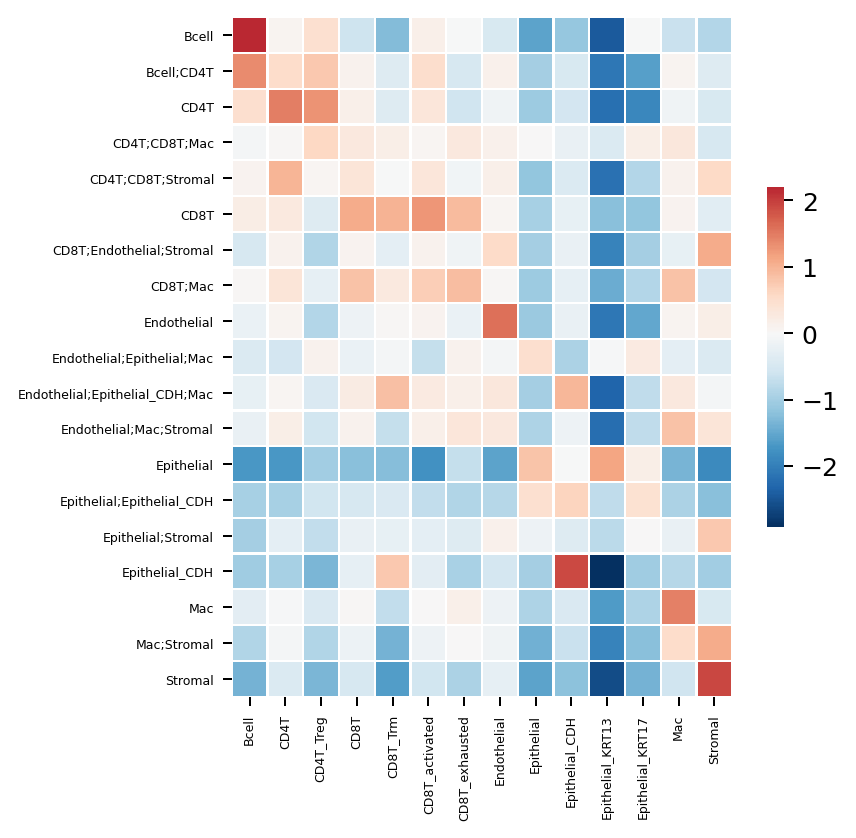

In [55]:
odf = odds_df.copy()
odf[odf == 0] = np.min(odf[odf>0].values)
odf = np.log10(odf)
na_odf = pd.isna(odf)
odf = odf.fillna(0)

plt.figure(figsize=(5,5), dpi=180)
ax = plt.gca()
sns.heatmap(odf, square=True, ax=ax, lw=0.5,  
            cmap='RdBu_r', center=0,
            cbar_kws=dict(shrink=0.5))
_ = ax.set_yticklabels(ax.get_yticklabels(), fontsize=5)
_ = ax.set_xticklabels(ax.get_xticklabels(), fontsize=5)

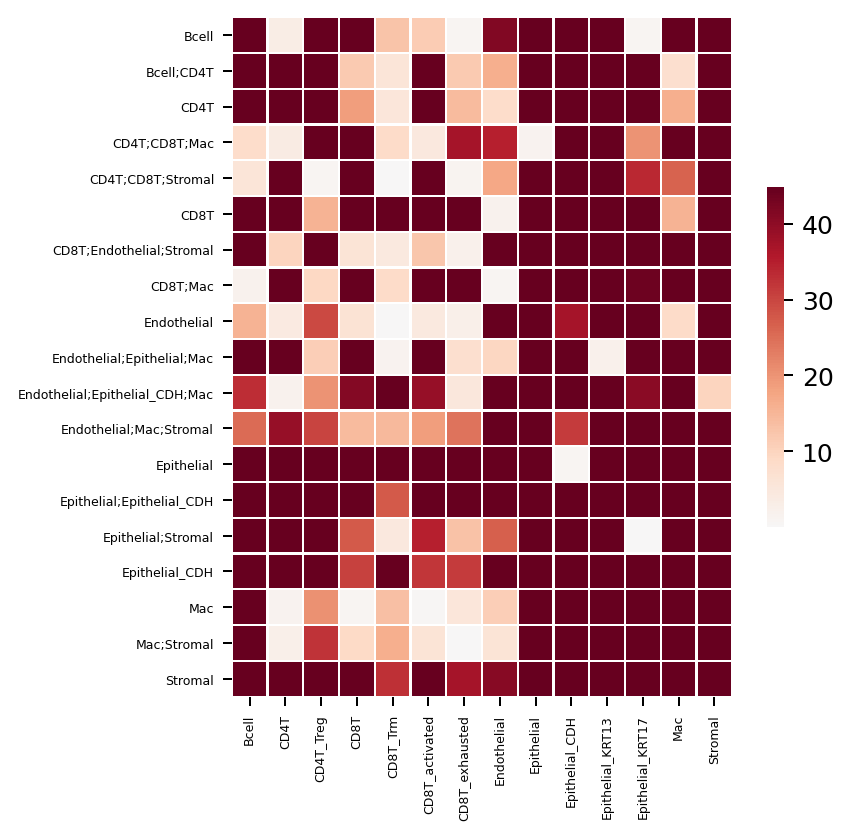

In [56]:
pdf = pval_df.copy()
pdf_np = np.array(pdf.values)
pdf[pdf == 0] = np.min(pdf_np[pdf_np>0])
pdf = -np.log10(pdf)
pdf[na_odf] = 1

plt.figure(figsize=(5,5), dpi=180)
ax = plt.gca()
sns.heatmap(pdf, square=True, ax=ax, lw=0.5,  
            cmap='RdBu_r', center=0,
            cbar_kws=dict(shrink=0.5))
_ = ax.set_yticklabels(ax.get_yticklabels(), fontsize=5)
_ = ax.set_xticklabels(ax.get_xticklabels(), fontsize=5)

In [42]:
pval_df

,Bcell,CD4T,CD4T_Treg,CD8T,CD8T_Trm,CD8T_activated,CD8T_exhausted,Endothelial,Epithelial,Epithelial_CDH,Epithelial_KRT13,Epithelial_KRT17,Mac,Stromal
Bcell,0.000000e+00,5.359743e-04,2.802597e-45,0.000000e+00,2.158457e-13,3.328970e-12,7.767427e-26,2.305136e-42,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
Bcell;CD4T,0.000000e+00,0.000000e+00,0.000000e+00,1.939476e-12,1.827565e-06,0.000000e+00,1.267355e-12,6.127790e-17,0.000000,0.000000e+00,0.000000,0.000000e+00,1.972367e-08,0.000000e+00
CD4T,0.000000e+00,0.000000e+00,0.000000e+00,2.541431e-19,2.405293e-06,0.000000e+00,8.432388e-15,7.328682e-09,0.000000,0.000000e+00,0.000000,0.000000e+00,3.620792e-17,0.000000e+00
CD4T;CD8T;Mac,7.285781e-09,2.572834e-04,0.000000e+00,0.000000e+00,1.877029e-09,1.221360e-05,6.710308e-38,1.878552e-35,0.035643,0.000000e+00,0.000000,4.867048e-21,0.000000e+00,0.000000e+00
CD4T;CD8T;Stromal,1.231009e-06,0.000000e+00,1.514583e-01,0.000000e+00,9.393096e-01,0.000000e+00,8.011457e-02,3.810774e-18,0.000000,0.000000e+00,0.000000,2.229199e-34,2.675413e-27,0.000000e+00
CD8T,1.401298e-45,0.000000e+00,3.491512e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.094131e-03,0.000000,0.000000e+00,0.000000,0.000000e+00,1.712378e-16,0.000000e+00
CD8T;Endothelial;Stromal,0.000000e+00,7.731033e-11,0.000000e+00,5.961646e-07,3.332852e-05,3.364533e-13,7.332683e-03,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
CD8T;Mac,1.221268e-02,0.000000e+00,6.000513e-10,0.000000e+00,2.001812e-09,0.000000e+00,0.000000e+00,1.480116e-01,0.000000,0.000000e+00,0.000000,9.809089e-45,0.000000e+00,0.000000e+00
Endothelial,2.796099e-16,8.560863e-05,1.737652e-30,2.844112e-07,6.411986e-01,5.145710e-05,2.992703e-03,0.000000e+00,0.000000,7.061114e-38,0.000000,0.000000e+00,2.212996e-09,0.000000e+00
Endothelial;Epithelial;Mac,0.000000e+00,0.000000e+00,9.613191e-12,0.000000e+00,2.142781e-02,0.000000e+00,2.629236e-08,2.433660e-10,0.000000,0.000000e+00,0.006866,0.000000e+00,0.000000e+00,0.000000e+00


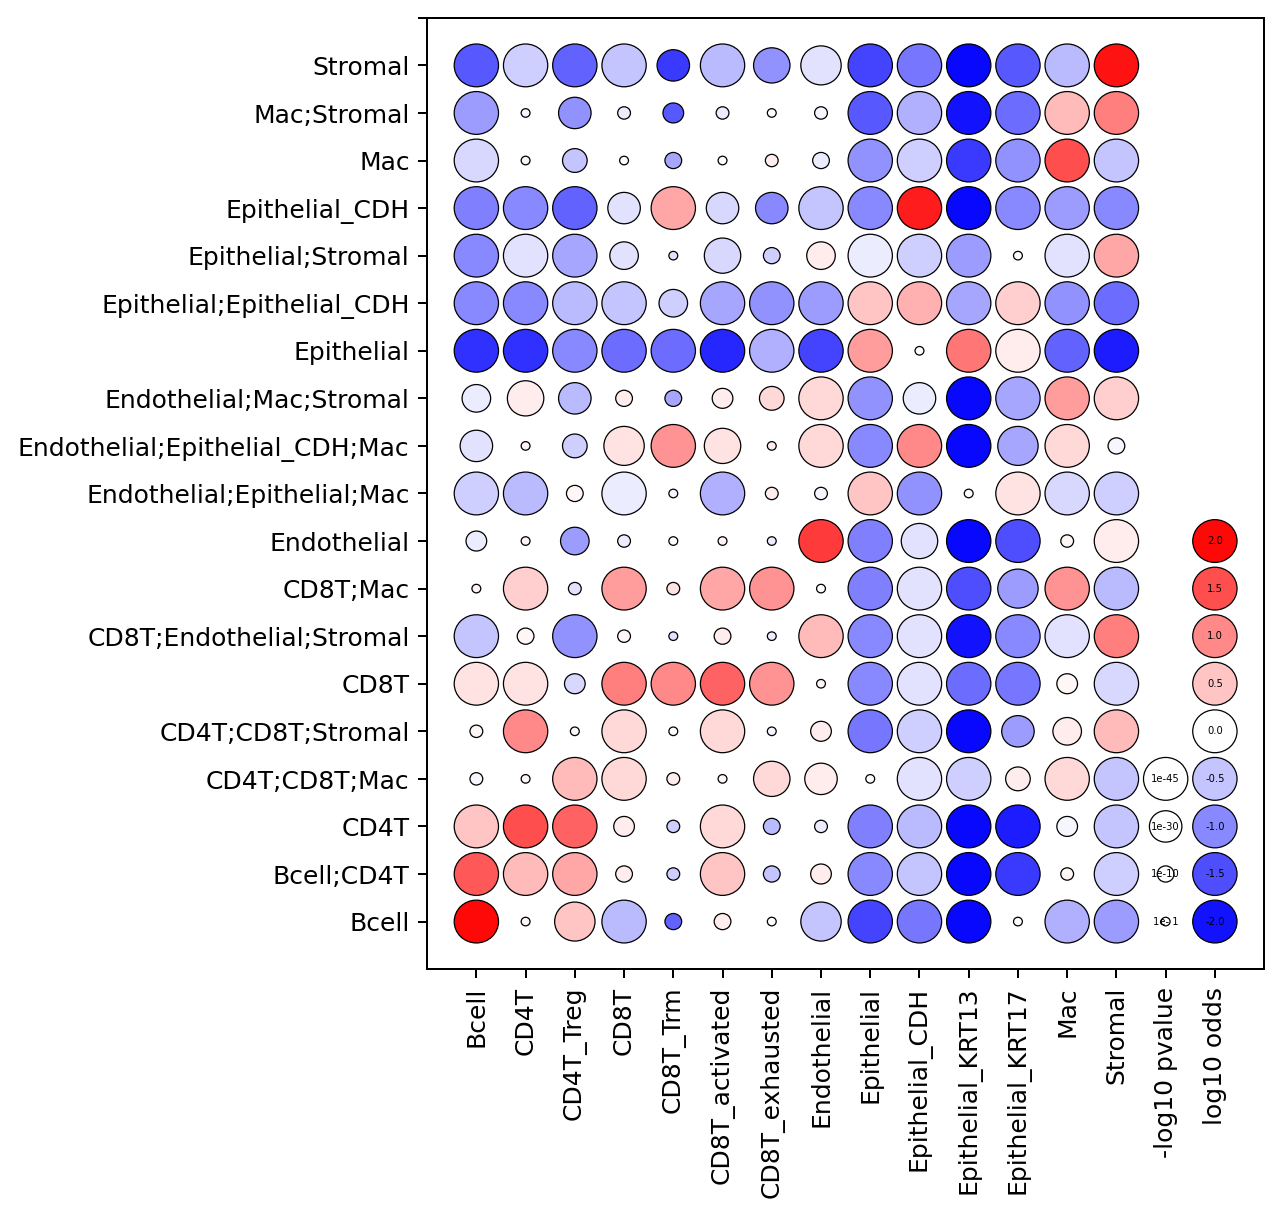

In [57]:
from matplotlib.patches import Circle
rcParams['svg.fonttype'] = 'none'
rcParams['figure.facecolor'] = (1,1,1,1)


max_size = 0.45
min_size = 0.05
size_scale = np.linspace(min_size, max_size, 11)
size_bins = np.linspace(0, np.max(pdf.values), 10)

min_enrich = -2
max_enrich = 2
cmap = np.array(sns.color_palette('bwr', 51))
enrich_bins = np.linspace(min_enrich, max_enrich, 50)

plt.figure(figsize=(6, 7), dpi=180)
ax = plt.gca()

for i,s in enumerate(u_subtypes):
    for j,f in enumerate(u_niches):
        p = np.digitize(pdf.loc[f,s], size_bins)
        e = np.digitize(odf.loc[f,s], enrich_bins)
        c = Circle((i,j), radius=size_scale[p], color=cmap[e], lw=0.5, ec='k')
        ax.add_artist(c)
        
# legends
for i,v in zip(range(4), [1, 10, 30, size_bins[-1]]):
    p = np.digitize(v, size_bins)
    coord = (len(u_subtypes), i)
    c = Circle(coord, radius=size_scale[p], color='w', lw=0.5, ec='k')
    ax.add_artist(c)
    ax.annotate(f'1e-{v:2.0f}', coord, fontsize=4, ha='center', va='center')
    
p = np.digitize(size_bins[-1], size_bins)
for i,v in zip(range(9), np.linspace(min_enrich, max_enrich, 9)):
    e = np.digitize(v, enrich_bins)
    coord = (len(u_subtypes)+1, i)
    c = Circle(coord, radius=size_scale[p], color=cmap[e], lw=0.5, ec='k')
    ax.annotate(f'{v:1.1f}', coord, fontsize=4, ha='center', va='center')
    ax.add_artist(c)
        
ax.set_xlim([-1,len(u_subtypes)+2])
ax.set_ylim([-1,len(u_niches)])
_ = ax.set_xticks(range(len(u_subtypes)+2))
_ = ax.set_yticks(range(len(u_niches)+1))
_ = ax.set_xticklabels(list(u_subtypes)+['-log10 pvalue', 'log10 odds'],rotation=90)
_ = ax.set_yticklabels(list(u_niches)+[''],rotation=0)


plt.savefig(f'figures/niche_subtype_association_fisher_test.svg', bbox_inches='tight', transparent=True)